## 1.4 Code

In [ ]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding
seed = 42
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Data Generator

In [ ]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, id_name):
        ## Path
        image_path = os.path.join(self.path, id_name, "images", id_name) + ".jpg"
        mask_path = os.path.join(self.path, id_name, "masks/")
        all_masks = os.listdir(mask_path)

        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))

        mask = np.zeros((self.image_size, self.image_size, 1))

        ## Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            mask = np.maximum(mask, _mask_image)

        ## Normalizing
        image = image/255.0
        mask = mask/255.0

        return image, mask

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size

        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]

        image = []
        mask  = []

        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)

        image = np.array(image)
        mask  = np.array(mask)

        return image, mask

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

## Hyperparameters

In [ ]:
image_size = 640
train_path = "C:/Users/NIT/Downloads/UnetFinal Data/"
epochs = 50
batch_size = 32

## Training Ids
train_ids = next(os.walk(train_path))[1]

## Validation Data Size
val_data_size = 52
print(len(train_ids))

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

552


In [ ]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(32, 640, 640, 3) (32, 640, 640, 1)


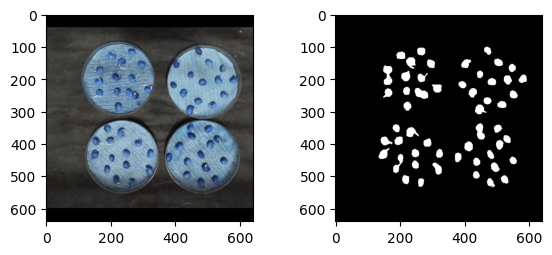

In [ ]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

## Different Convolutional Blocks

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

# Define FCN-VGG16 architecture
def fcn_vgg16(input_shape, num_classes):
    inputs = Input(shape=input_shape, name='input_image')

    # Load VGG16 model without top classification layers
    vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

    # Freeze VGG16 layers
    for layer in vgg16.layers:
        layer.trainable = False

    # Add convolutional layers for segmentation
    x = Conv2D(4096, (7, 7), activation='relu', padding='same')(vgg16.layers[-1].output)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = Conv2D(4096, (1, 1), activation='relu', padding='same')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Output layer for segmentation
    output = Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(x)

    return tf.keras.Model(inputs=inputs, outputs=output)

# Define U-Net decoder
def unet_decoder(input_tensor, skip_connections, num_classes):
    x = input_tensor

    # Upsampling blocks
    for i in range(len(skip_connections)):
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, skip_connections[i]])
        x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    # Output layer for segmentation
    output = Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(x)

    return output

# Create the FCN-VGG16 with U-Net model
def fcn_vgg16_unet(input_shape, num_classes):
    # FCN-VGG16 encoder
    fcn_vgg16_encoder = fcn_vgg16(input_shape, num_classes)

    # U-Net decoder
    skip_connections = [fcn_vgg16_encoder.get_layer('block4_pool').output,
                        fcn_vgg16_encoder.get_layer('block3_pool').output,
                        fcn_vgg16_encoder.get_layer('block2_pool').output]

    u_net_output = unet_decoder(fcn_vgg16_encoder.output, skip_connections, num_classes)

    # Create the model
    model = tf.keras.Model(inputs=fcn_vgg16_encoder.input, outputs=u_net_output)

    return model

# Define input shape and number of classes
input_shape = (640, 640, 3)  # Adjust to your desired image size and number of channels
num_classes = 1  # Adjust for your specific segmentation task

# Create and compile the model
model = fcn_vgg16_unet(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 640, 640, 64  1792        ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 640, 640, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

 up_sampling2d_2 (UpSampling2D)  (None, 160, 160, 25  0          ['conv2d_6[0][0]']               
                                6)                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 160, 160, 38  0           ['up_sampling2d_2[0][0]',        
                                4)                                'block2_pool[0][0]']            
                                                                                                  
 conv2d_7 (Conv2D)              (None, 160, 160, 25  884992      ['concatenate_2[0][0]']          
                                6)                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 160, 160, 25  590080      ['conv2d_7[0][0]']               
          

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate
from tensorflow.keras.applications import VGG16

# Define the U-Net architecture with VGG16 encoder
def unet_vgg16(input_shape=(640, 640, 3), num_classes=1):
    # Load the VGG16 model with pretrained weights from PASCAL VOC
    vgg16 = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')

    # Use VGG16 layers as encoder
    encoder = vgg16.get_layer('block5_conv3').output

    # Decoder
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoder)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    # Repeated Criss-Cross Attention (RCCA)
    # Add your RCCA layers here

    # Upsampling
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (2, 2), activation='relu', padding='same')(x)

    # Skip connection from VGG16
    skip_connection = vgg16.get_layer('block4_conv3').output
    x = Concatenate()([x, skip_connection])

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (2, 2), activation='relu', padding='same')(x)

    skip_connection = vgg16.get_layer('block3_conv3').output
    x = Concatenate()([x, skip_connection])

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)

    skip_connection = vgg16.get_layer('block2_conv2').output
    x = Concatenate()([x, skip_connection])

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(num_classes, (1, 1), activation='sigmoid')(x)

    model = keras.models.Model(inputs=vgg16.input, outputs=x)

    return model

model = unet_vgg16(input_shape=(640, 640, 3), num_classes=1)




## UNet Model

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 640, 640, 64  1792        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 640, 640, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

                                8)                                                                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 160, 160, 12  147584      ['conv2d_28[0][0]']              
                                8)                                                                
                                                                                                  
 up_sampling2d_8 (UpSampling2D)  (None, 320, 320, 12  0          ['conv2d_29[0][0]']              
                                8)                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 320, 320, 64  4160        ['block1_pool[0][0]']            
                                )                                                                 
          

## Training the model

In [ ]:
from tensorflow.keras.callbacks import TensorBoard


train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

tensorboard_callback = TensorBoard(log_dir='C:/Users/NIT/Downloads', histogram_freq=1)


model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps,
                    validation_steps=valid_steps, epochs=epochs)


C:\Users\NIT\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
15/15 [==============================] - 1093s 72s/step - loss: 0.8696 - accuracy: 0.7731 - val_loss: 0.3183 - val_accuracy: 0.8873
Epoch 2/50
15/15 [==============================] - 776s 52s/step - loss: 0.2601 - accuracy: 0.8931 - val_loss: 0.1991 - val_accuracy: 0.8938
Epoch 3/50
15/15 [==============================] - 823s 55s/step - loss: 0.1718 - accuracy: 0.9138 - val_loss: 0.1389 - val_accuracy: 0.9215
Epoch 4/50
15/15 [==============================] - 744s 50s/step - loss: 0.1467 - accuracy: 0.9242 - val_loss: 0.1962 - val_accuracy: 0.8932
Epoch 5/50
15/15 [==============================] - 773s 52s/step - loss: 0.1494 - accuracy: 0.9227 - val_loss: 0.1192 - val_accuracy: 0.9326
Epoch 6/50
15/15 [==============================] - 838s 56s/step - loss: 0.1237 - accuracy: 0.9294 - val_loss: 0.1274 - val_accuracy: 0.9278
Epoch 7/50
15/15 [==============================] - 818s 54s/step - loss: 0.1366 - accuracy: 0.9265 - val_loss: 0.1425 - val_accuracy: 0.9220
Epoch

## Testing the model

In [ ]:
## Save the Weights
model.save_weights("UNetWOGVGG.h5")

## Dataset for prediction
x, y = valid_gen.__getitem__(0)
result = model.predict(x)

result = result > 0.5

1/1 [==============================] - 10s 10s/step


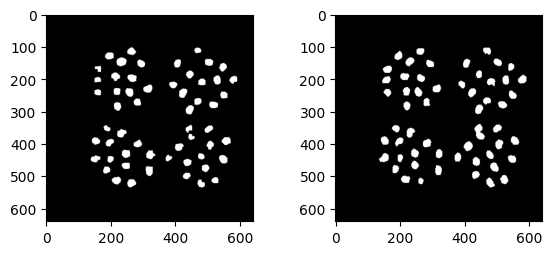

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")